In [ ]:
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from models.vae import VAE
from utils.poreDataset import PoreDataset
from utils.visualisation import plot_pore_reconstruction, generate_pore_grid, intersection_over_union, misclassified_ones


****
# Dataset Loader
****

In [2]:
data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

dataset = PoreDataset(npy_files)
total_size = len(dataset)
val_size = int(total_size * 0.1)
train_size = total_size - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

****
# Model Training
****

In [3]:
model_train = VAE(latent_dim=256, 
            lr=1e-5, 
            alpha=0.9, 
            gamma=2,
            beta = 0,
            lambda_edge=0.1,
            lambda_cluster=0.3)


trainer = pl.Trainer(max_epochs=50, 
                     accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     log_every_n_steps=1,
                     callbacks=[
            # EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best_reconstructor")
                     ],
                     default_root_dir=parent_dir,
)

trainer.fit(model_train, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | encoder       | Sequential | 1.2 M  | train
1 | fc_mu         | 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=51` in the `DataLoader` to improve performance.


/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=51` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 29/29 [00:15<00:00,  1.81it/s, v_num=2, train_loss_step=0.0685, val_loss=0.0856, train_loss_epoch=0.0793]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 29/29 [00:15<00:00,  1.81it/s, v_num=2, train_loss_step=0.0685, val_loss=0.0856, train_loss_epoch=0.0793]


****
# Results
****

## Model load

In [4]:
model_path = os.path.join(parent_dir,"lightning_logs", "version_2")

ckpt_path = os.path.join(model_path, "checkpoints", "best_reconstructor.ckpt")
model_load = VAE(latent_dim=256, 
            lr=1e-5, 
            alpha=0.9, 
            gamma=2,
            beta = 0,
            lambda_edge=0.1,
            lambda_cluster=0.3)

model_load.load_state_dict(torch.load(ckpt_path)["state_dict"])
model_load.eval()

VAE(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (10): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=16384, out_features=256, bias=True)
  (decoder_input): Linear

## Metrics

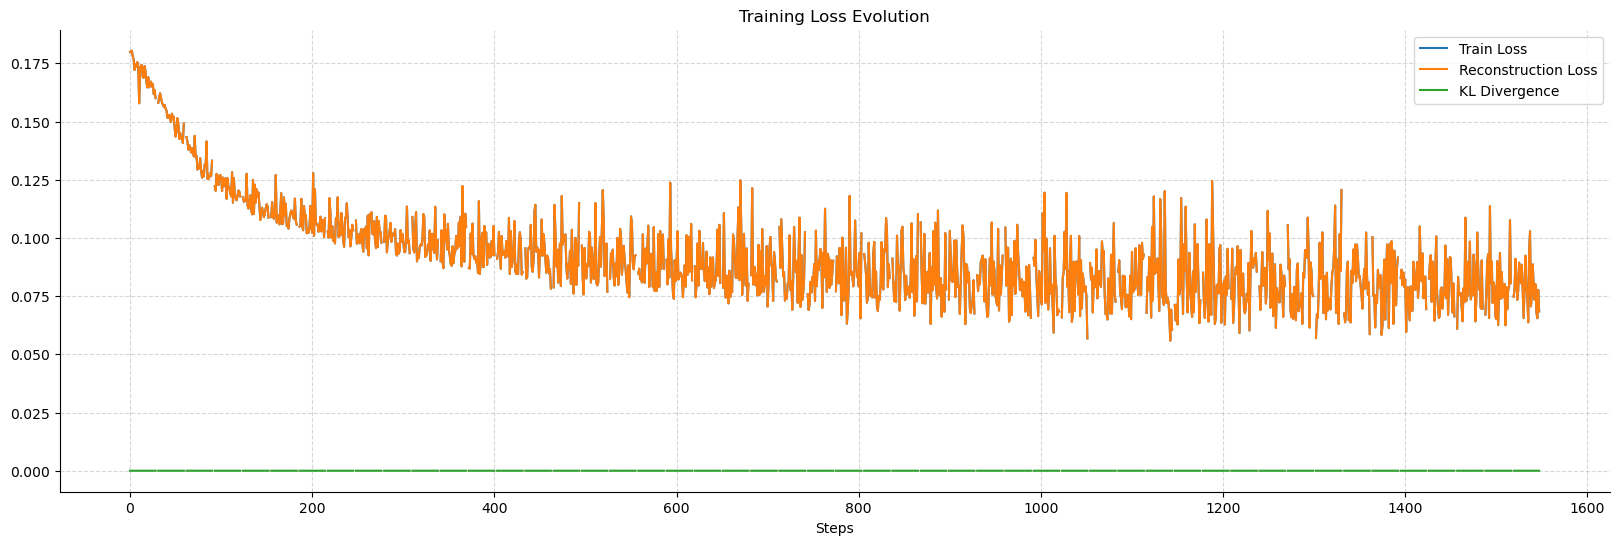

In [5]:
metrics = pd.read_csv(os.path.join(model_path, "metrics.csv"))

plt.figure(figsize=(20, 6))
plt.plot(metrics["train_loss_step"], label='Train Loss')
plt.plot(metrics["reconstruction_loss"], label='Reconstruction Loss')
plt.plot(metrics["kl_divergence"], label='KL Divergence')
plt.title("Training Loss Evolution")
plt.xlabel('Steps')
plt.ylabel('')
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.ylim((0,0.5))
plt.legend()
plt.show()

## Reconstruction of existing grid

IoU Score: 0.2054
Number of ones: 5025.0
Missclassified ones: 6475.0
False negatives: 3351.0
False positives: 3124.0


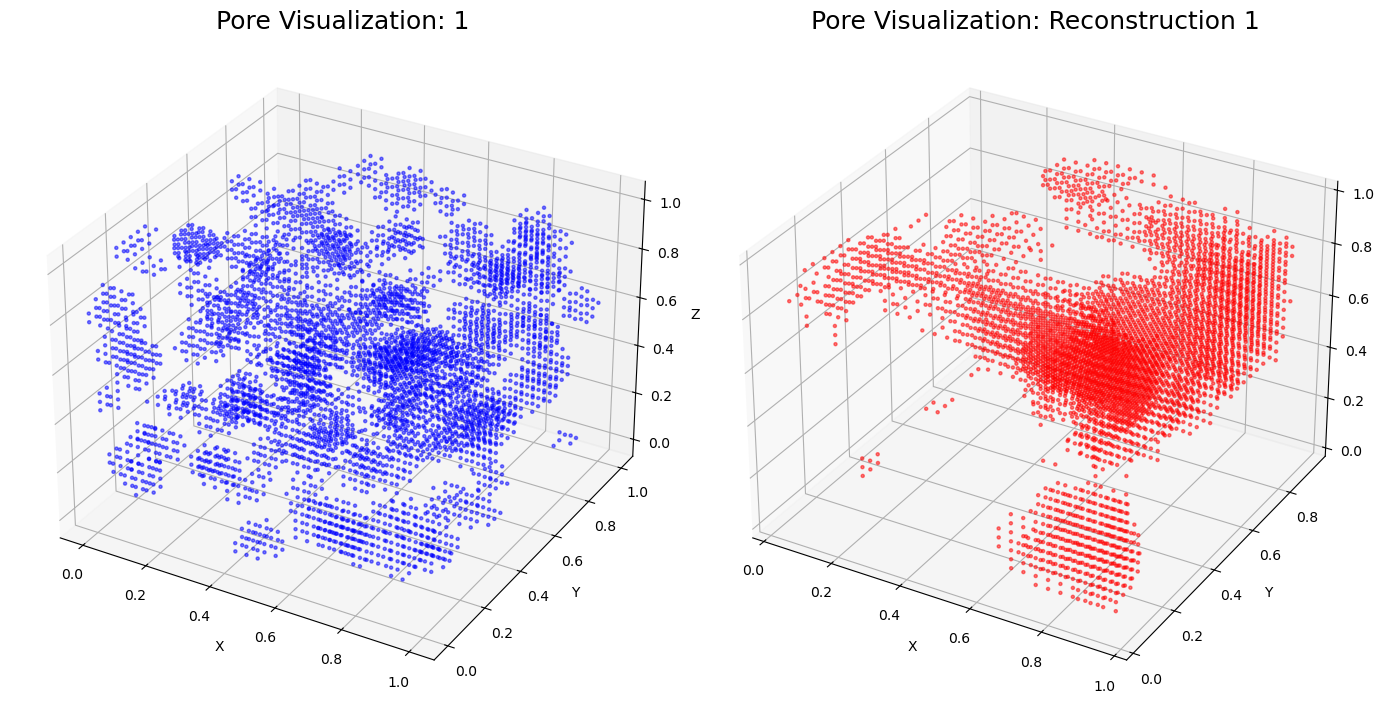

In [10]:
index = 1
grid_truth, d_truth = dataset.__getitem__(index)

with torch.no_grad():
    grid_reco, mu, logvar = model_load(grid_truth.unsqueeze(0), d_truth.unsqueeze(0))

    iou_score = intersection_over_union(grid_truth.squeeze(), grid_reco.squeeze(), d_truth)
    miss_ones, false_negative, false_positives = misclassified_ones(grid_truth.squeeze(), grid_reco.squeeze(), d_truth)
    print(f"IoU Score: {iou_score.item():.4f}")
    print(f"Number of ones: {grid_truth.sum()}")
    print(f"Missclassified ones: {miss_ones}")
    print(f"False negatives: {false_negative}") #Ones in ground truth missing in prediction
    print(f"False positives: {false_positives}") #Ones in prediction that should be zero
    plot_pore_reconstruction(grid_truth.squeeze(), grid_reco.squeeze(), index, f"Reconstruction {index}", d_truth)

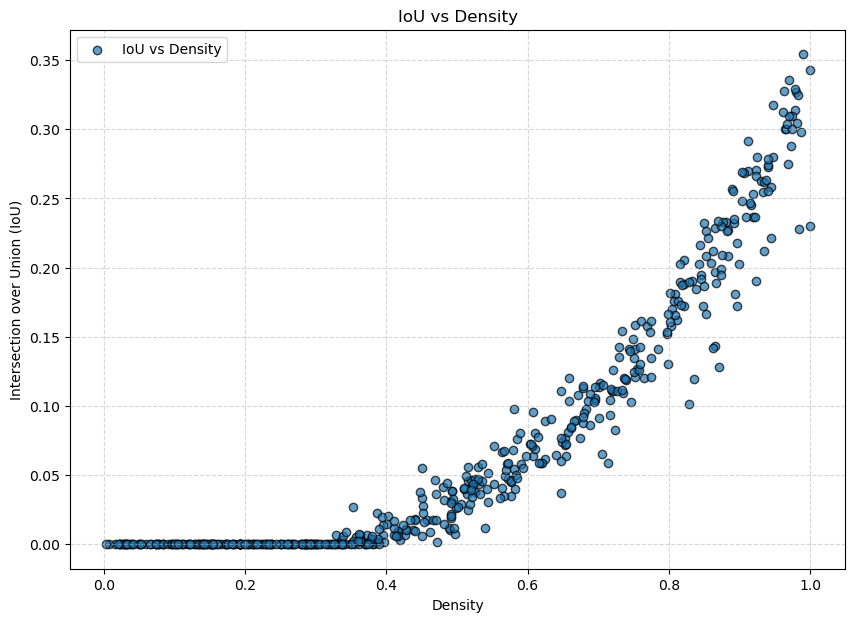

In [7]:
# Load all data at once
all_data = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

for grids, densities in all_data:
    all_grids = grids 
    all_densities = densities 
    break

model_load.eval()
with torch.no_grad():
    recos, _, _ = model_load(all_grids, all_densities)

ious = []
densities_array = []
for i in range(all_grids.shape[0]):
    densities_array.append(all_densities[i].item())
    ious.append(intersection_over_union(all_grids[i].squeeze(), recos[i].squeeze(), all_densities[i]).item())

plt.figure(figsize=(10, 7))
plt.scatter(densities_array, ious, alpha=0.7, label="IoU vs Density", edgecolors="k")
plt.xlabel("Density")
plt.ylabel("Intersection over Union (IoU)")
plt.title("IoU vs Density")
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.legend()

# Show the plot
plt.show()

In [8]:
print(grid_reco.quantile(0.25).item(), grid_reco.quantile(0.5).item(), grid_reco.quantile(0.75).item())
print(grid_reco.min().item(), grid_reco.max().item())

0.31049689650535583 0.38861823081970215 0.4603361487388611
0.10849057883024216 0.6679126024246216


## Generation of grid based on density factor

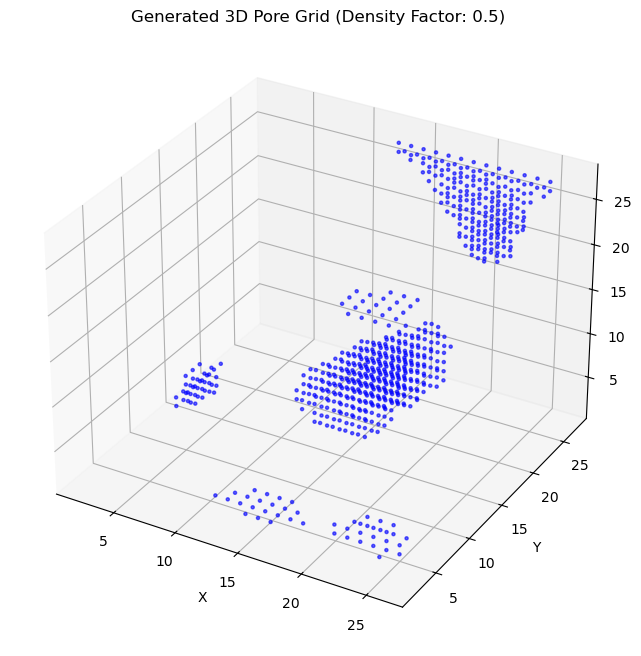

In [20]:
from utils.visualisation import generate_pore_grid

generate_pore_grid(model_load, 0.5, random_sample=True)

## Compute latent representations

In [21]:
# Load all data at once
data_latent_space = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

for grids, densities in data_latent_space:
    all_grids = grids
    all_densities = densities 
    break

model_load.eval()
with torch.no_grad():
    recos, mus, logvars = model_load(all_grids, all_densities) 

In [11]:
# Significant differences bewtween significantly different inputs: looks like there is no posterior collapse
print((mus[0] - mus[1]).max(), (logvars[0] - logvars[1]).max())

tensor(5.4441) tensor(4.0996)
